# NeuroAdventure concepts - Chatbot for children

Chatbot for children is a main component of the entire NeuroAdventure app and provides other components with information on child and conversation states. Chatbot is powered by LangGraph package (see more: [LangGraph website](https://langchain-ai.github.io/langgraph/)). LangGraph not only allows us to write prompts programatically directly to the api but also to create graphs which are agentic workflows performing LLM operations divided on steps.


Key features of the chatbot are:
- Assessment of probability if previous messages concern a social scenario experienced by a child;
- Evaluation of probability if previous messages describe emotions felt\being felt by a child;
- Sentimet analysis of messages which estimate current mood of a child;
- Response generator - creates a LLM model response based on information given e.g. age, language, mood and other factors;   

### LLM initialization

Install required packages

In [1]:
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Env variables initialization

In [2]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [3]:
import getpass
import os

def _set_env(var: str):
    if not os.getenv(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

Set neccessary api keys and other environment variables

In [4]:
_set_env("OPENAI_API_KEY")

In [5]:
_set_env("LANGCHAIN_API_KEY")

In [6]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "neuroadventure"

Init the LLM  model to work with

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=1) 

### LangGraph state declaration

State is a main part of the graph which gathers and stores all infomation neccessary for LLM agent to work with and generate a satisfying, engaging and desired output. For the children chatbot, we need to store below values:
- messages - history of all messages exchanged between the LLM model and a child, including first system message ([More on system messages](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.system.SystemMessage.html));
- name - LLM model uses a child name to sound more natural and persuasive;
- age - LLM model takes into account an age of a child to create a well-tailored content e.g. older children might prefer more serious responses;
- diagnosis - describes neurodivergence of a child, thus if they have adhd or are in autism spectrum 
- langauge - ISO code which specifes language of the responses;
- mood - estimated mood experienced by a child during the conversation;
- summary - summary of messages;
- isSocialContext - boolean which determines if a social scenario expierenced by a child is presented in the chat history;
- isEmotionalContext - boolean which determines if previous messages were describing emotions of a child.

In [8]:
# import pydantic to validate data passed to the state
from pydantic import BaseModel, field_validator, Field

# langgraph use Annotated to let us declare a reducer function which update a given state key
from typing import Annotated, Any

# import to show a graphical representation of the graph
from IPython.display import Image, display

#import langgraph modules
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph.message import add_messages

from helpers.validation import DiagnosisType, MoodType
from helpers.enum import MoodEnum

class ChildState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    name: str
    age: int 
    diagnosis: DiagnosisType
    language: str
    mood: MoodType = MoodEnum.NEUTRAL
    isSocialContext: bool = False
    isEmotionalContext: bool = False

    @field_validator('age')
    @classmethod
    def validate_age(cls, value):
        # Ensure the person is a child
        if value >= 18:
            raise ValueError("The person is not a child")
        return value

    @field_validator('language')
    @classmethod
    def validate_language(cls, value):
        # Ensure the language code is proper according to ISO standards
        if len(value) != 2:
            raise ValueError("Given language is not valid language code")
        return value

### Assessing social context

Children using chatbot will often pass messages which have a social scenerio context in place (e.g. situations in school, playing with other kids etc.). The LLM model should be able to assess if any social context can be indeed identified in the messages. That will help the further nodes to properly text back the child.

In [9]:
#create a formatter to store probability of social context occurence within LLM message in a given format (float)
class SocialFormatter(BaseModel):
  social_p: float = Field(description='Probability of social context occurence')

#node for the graph
def assess_social_context(state: ChildState):
  socialContextPrompt = """You are a therapist of neurodivergent children. Neurodivergent kid is talking with you. Assess the probability [social_p], from 0 to 1, 
  that content of previous messages concerns social scenario experienced by a child. Remember that you should assess only HumanMessages, the ones written by a child."""
  
  llm_with_structured_output = llm.with_structured_output(SocialFormatter)
  messages = add_messages(state.messages, HumanMessage(content=socialContextPrompt))

  probability = llm_with_structured_output.invoke(messages)

  if probability.social_p >= 0.75:
    return {'isSocialContext': True}
  else:
    return {'isSocialContext': False}

### Assessing emotional context

It is hard for children in autism spectrum to correctly get their emotions across. The LLM model should also assess if a content of messages involves any emotions. An example is a situation when a child write a prompt about a situation in school which could involve happiness e.g. getting a very good grade. However, those emotions will not be directly expressed. LLM model tries to identify those emotions via content of messages. For example, a scientific question will be assesed as not emotionally affected.

In [10]:
#create a formatter to store probability of emotional context occurence within LLM message in a given format (float)
class EmotionFormatter(BaseModel):
  emotion_p: float = Field(description='Probability of emotion occurence')

#node for the graph
def assess_emotional_context(state: ChildState):
  emotionContextPrompt = """You are a therapist of neurodivergent children. Neurodivergent kid is talking with you. Assess the probability [emotion_p], from 0 to 1, 
  that content of previous messages can involve any child's emotions. Remember that you should assess only HumanMessages, the ones written by a child"""
  
  llm_with_structured_output = llm.with_structured_output(EmotionFormatter)
  messages = add_messages(state.messages, HumanMessage(content=emotionContextPrompt))

  probability = llm_with_structured_output.invoke(messages)

  if probability.emotion_p >= 0.75:
    return {'isEmotionalContext': True}
  else:
    return {'isEmotionalContext': False}

### Analyzing mood

The analysis of mood of a child is very important from the perspective of how the next messages should be expressed by LLM model. If the kid is sad the LLM model should cheer them a bit. On the other hand, if the child is happy, then LLM model should praise for such a behaviour and continue the conversation in the way which supports that emotion.

In [11]:
#create a formatter to store probability of emotional context occurence within LLM message in a given format (float)
class SentimentFormatter(BaseModel):
  sentiment: MoodEnum = Field(description="""One of the moods from ['happy', 'sad', 'neutral', 'nervous', 'irritated', 'curious']""")

#node for the graph
def analyze_mood(state: ChildState):

  def moodAnalyzePrompt():
    #create a string from enum of moods given
    accessible_moods = ', '.join([e.value for e in MoodEnum])
    return (f"""You are a therapist of neurodivergent children. Assess the sentiment of previous messages (mood of a child) in one 
    of those emotions: {accessible_moods}. Remember that you should assess only HumanMessages, the ones written by a child. Additionally, if you think 
    that more than adjective complies with the criteria, then pick the one which describe better the newest messages""")
  
  llm_with_structured_output = llm.with_structured_output(SentimentFormatter)
  messages = add_messages(state.messages, HumanMessage(content=moodAnalyzePrompt()))

  sentiment = llm_with_structured_output.invoke(messages)

  if sentiment.sentiment is not None:
    return {'mood': sentiment.sentiment.value}
  else:
    return {'mood': state.mood}

### Generating the response

In [12]:
from helpers.messages import format_messages_for_prompt
from helpers.formatter import FormatDiagnosis

#Generate the LLM model response based on current state
def generate_response(state: ChildState):
    
    #Get current values from the state
    child_current_mood = state.mood
    social_context_present = state.isSocialContext
    emotional_context_present = state.isEmotionalContext
    child_name = state.name
    child_diagnosis = state.diagnosis
    child_age = state.age
    language = state.language

    #Format recent messages for context
    formatted_history = format_messages_for_prompt(state.messages)

    def childChatBotSystemMessage(diagnosis: DiagnosisType, age: int):
        return (f'''Pretend to be a terapist who talks with a neurodivergent kid. Their diagnosis is {FormatDiagnosis(diagnosis)}. Kid is {age} years old. 
                Remember that neurodivergent kids have special language needs. You should be very detailed but concise in the same time.''')

    #Instruction for a response generation
    def responsePrompt(social_context: bool, emotional_context: bool, mood: str, name: str, language: str, history: str):
        return(f"""
            As a therapist create a response to a message of a neurodivergent child.

            RESPONSE RULES:
            - Current mood of a child is: {mood}
            - If mood is 'sad', 'nervous', or 'irritated': Generate a calming, validating, supportive message.
            - If mood is 'happy' or 'curious': Generate a praising, encouraging, engaging message. 
            - If mood is 'neutral', generate message which will try changin the mood to 'happy' or 'curious'.
            - If Social Context Present is False (Current state: {social_context}): Make the response have a question 
                which would cause a child to share experienced social scenario but if there is a factual question/statement in place also respond clearly. 
                The question should be connected with a factual question/statement and very precise (about one concrete social scenario). 
            - If Emotional Context Present is False (Current state: {emotional_context}): Make the response have a question or statement 
                which would cause a child to share experienced emotions but if there is a factual question/statement in place also respond clearly.
                The question should be connected with a factual question/statement and very precise (about one concrete emotion). 
            - If both contexts are False, you can combine the questions or choose one.
            - Address the child by name ({name}) occasionally.
            - Respond ONLY in language: {language}.

            RECENT CONVERSATION HISTORY:
            {history}

            Based on the rules and context above, generate your response to the child's last message.
            Generate ONLY the response text.
        """
        )

    #Construct the prompt 
    prompt_template = ChatPromptTemplate.from_messages([
        SystemMessage(content=childChatBotSystemMessage(child_diagnosis, child_age)),
        HumanMessage(content=responsePrompt(social_context_present, emotional_context_present, child_current_mood, child_name, language, formatted_history))
    ])

    #Invoke the LLM with the constructed prompt
    chain = prompt_template | llm
    response_content = chain.invoke({}).content # Pass empty dict as input because template handles entire necessary context 

    # Return the message to be added to the state
    # LangGraph's `add_messages` handles appending this
    return {"messages": [AIMessage(content=response_content)]}

### Formulating a graph

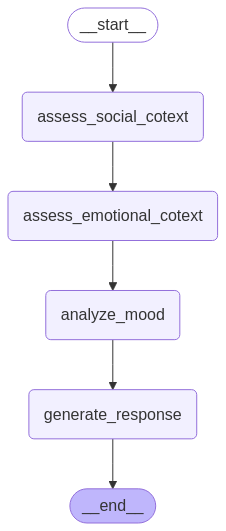

In [13]:
workflow = StateGraph(ChildState)
workflow.add_node("assess_social_cotext", assess_social_context)
workflow.add_node("assess_emotional_cotext", assess_emotional_context)
workflow.add_node("analyze_mood", analyze_mood)
workflow.add_node("generate_response", generate_response)

workflow.add_edge(START, "assess_social_cotext")
workflow.add_edge("assess_social_cotext", "assess_emotional_cotext")
workflow.add_edge("assess_emotional_cotext", "analyze_mood")
workflow.add_edge("analyze_mood", "generate_response")
workflow.add_edge("generate_response", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Example response

In [14]:
exampleChild = {
  'messages': [HumanMessage(content='Kim był Napoleon Bonaparte?')],
  'name': 'Adrian',
  'age': 12,
  'diagnosis': {'adhd': False, 'spectrum': True},
  'language': 'pl'
}

config = {"configurable": {"thread_id": "test"}}

graph.invoke(exampleChild, config)

{'messages': [HumanMessage(content='Kim był Napoleon Bonaparte?', additional_kwargs={}, response_metadata={}, id='c26bafbf-59b7-443c-b2c8-bb4b256c5de9'),
  AIMessage(content='Napoleon Bonaparte był jednym z najważniejszych dowódców wojskowych i przywódców Francji. Żył na przełomie XVIII i XIX wieku i był znany z tego, że stał się cesarzem Francuzów oraz prowadził liczne kampanie wojenne, na przykład w Europie. Wiesz może, jak to było żyć w tamtych czasach, Adrian? Czy wyobrażałeś sobie kiedyś, jakie emocje wtedy towarzyszyłyby takim wydarzeniom?', additional_kwargs={}, response_metadata={}, id='1c36e1bf-2e69-4bba-80ad-5fea31c4575c')],
 'name': 'Adrian',
 'age': 12,
 'diagnosis': {'adhd': False, 'spectrum': True},
 'language': 'pl',
 'mood': 'curious',
 'isSocialContext': False,
 'isEmotionalContext': False}